In [130]:
%matplotlib inline
import random
from math import sqrt, log, floor
from dtw import dtw
from fastdtw import fastdtw
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, mean_squared_error

sns.set(style='white')

In [13]:
data = pd.read_csv('data/train.txt', header=None, delim_whitespace=True)
# data normalization
for column in range(2, 26):
    data[column] = (data[column] - data[column].mean()) / data[column].std()
data.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.946633,-1.032857,-0.897512,0.611799,0.656125,0.747996,0.872271,0.686528,...,0.768702,0.420043,0.650642,-0.945465,1.407503,0.707894,0.622245,0.419839,0.787906,0.792200
1,1,2,-1.622814,-1.836240,1.563749,1.731217,1.672411,1.548658,1.658630,1.816899,...,1.851910,0.420198,0.792348,-1.252581,1.407503,1.534115,1.095841,0.419839,1.839028,1.833676
2,1,3,0.742866,0.864646,0.333118,-0.885167,-0.646592,-0.487151,-0.695764,-0.703003,...,-0.598445,0.418641,-0.020112,0.030947,-0.710463,-0.513475,-0.036670,0.419839,-0.600465,-0.607676
3,1,4,-0.270777,0.415677,-1.512828,0.692676,0.733684,0.644408,0.363952,0.363958,...,0.353904,0.419576,-0.155934,-0.145421,-0.710463,0.564204,0.656564,0.419839,0.367860,0.389925
4,1,5,1.216413,0.865932,-0.282197,-1.052966,-0.804384,-0.615953,-0.680456,-1.135852,...,-0.980745,0.418174,0.213280,-0.045000,-0.710463,-0.657166,-0.112171,0.419839,-0.988199,-1.020503


## Chunk creation

In [98]:
grouped = data.groupby(0)
series = [group.drop(labels=[0,1], axis=1) for name, group in grouped]

k = 6
chunk_length = 10

train_set = []
true_labels = []
for serie in series:
    reversed_serie = serie.iloc[::-1]
    for i in range(len(serie) // chunk_length):        
        chunk = reversed_serie[i*10:(i+1)*10]
        true_label = i
        train_set.append(chunk)
        true_labels.append(true_label)

In [99]:
#sampling
n = 100
indices = random.sample(list(range(len(train_set))), k=n) 
sample = [train_set[i] for i in indices]
sample_labels = [true_labels[i] for i in indices]

In [100]:
euclidean_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        euclidean_distances[i,j] = euclidean(sample[i].values.flatten(), sample[j].values.flatten())
euclidean_distances.shape
#np.save('dtw_distances.npy', dtw_distances)

(100, 100)

In [101]:
rmse_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        rmse_distances[i,j] = sqrt(mean_squared_error(sample[i].values.flatten(), sample[j].values.flatten()))
rmse_distances.shape

(100, 100)

In [102]:
def lcs(a, b):
    
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    x, y = len(a), len(b)
    result = lengths[x][y]
    return result

In [104]:
def dtw(x, y):
    dist, _ = fastdtw(x, y, dist=euclidean)
    return dist

# DTW is very slow so we precomputed the distances using
dtw_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        dtw_distances[i,j] = dtw(sample[i], sample[j])
# np.save('dtw_distances.npy', dtw_distances)

In [118]:
def discretise(x):
    return int(x * 10)

def multidim_lcs(a, b):
    a = a.applymap(discretise)
    b = b.applymap(discretise)
    rows, dims = a.shape
    lcss = [lcs(a[i+2], b[i+2]) for i in range(dims)]
    return 1 - sum(lcss) / (rows * dims)

0.5583333333333333

In [119]:
lcs_distances = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        lcs_distances[i,j] = multidim_lcs(sample[i], sample[j])

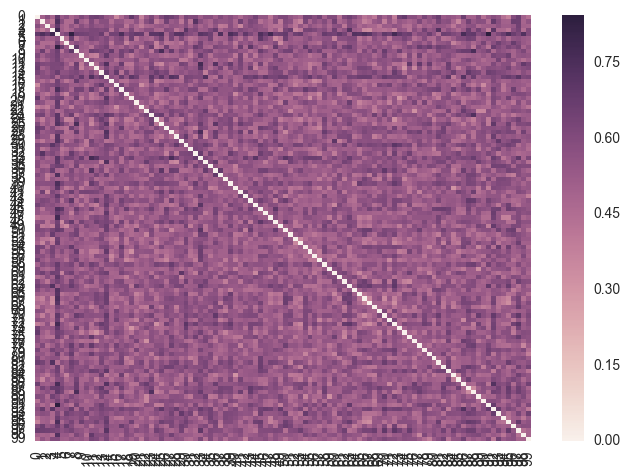

In [121]:
sns.heatmap(lcs_distances)

## Clustering algorithms

In [122]:
k = 6
y_pred_km_euc = KMeans(n_clusters=k).fit_predict(euclidean_distances)
y_pred_km_dtw = KMeans(n_clusters=k).fit_predict(dtw_distances)
y_pred_km_rmse = KMeans(n_clusters=k).fit_predict(rmse_distances)
y_pred_km_lcs = KMeans(n_clusters=k).fit_predict(lcs_distances)

In [123]:
y_pred_hac_euc = AgglomerativeClustering(n_clusters=k).fit_predict(euclidean_distances)
y_pred_hac_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(dtw_distances)
y_pred_hac_rmse = AgglomerativeClustering(n_clusters=k).fit_predict(rmse_distances)
y_pred_hac_lcs = AgglomerativeClustering(n_clusters=k).fit_predict(lcs_distances)

## Evaluation

In [124]:
# True label normalisation
log_base = max(true_labels)**(1 / k) + 0.05
normalised_true_labels = [floor(log(l+1, log_base)) for l in sample_labels]

In [125]:
print(normalized_mutual_info_score(normalised_true_labels, y_pred_km_euc),
normalized_mutual_info_score(normalised_true_labels, y_pred_km_dtw),
normalized_mutual_info_score(normalised_true_labels, y_pred_km_rmse),
normalized_mutual_info_score(normalised_true_labels, y_pred_km_lcs),
normalized_mutual_info_score(normalised_true_labels, y_pred_hac_euc),
normalized_mutual_info_score(normalised_true_labels, y_pred_hac_dtw),
normalized_mutual_info_score(normalised_true_labels, y_pred_hac_rmse),
normalized_mutual_info_score(normalised_true_labels, y_pred_hac_lcs))

0.139250706118 0.0805973483941 0.110597807888 0.154444546705 0.0980120221841 0.110869825539 0.0980120221841 0.143587942618


In [126]:
print(adjusted_rand_score(normalised_true_labels, y_pred_km_euc),
adjusted_rand_score(normalised_true_labels, y_pred_km_dtw),
adjusted_rand_score(normalised_true_labels, y_pred_km_rmse),
adjusted_rand_score(normalised_true_labels, y_pred_km_lcs),
adjusted_rand_score(normalised_true_labels, y_pred_hac_euc),
adjusted_rand_score(normalised_true_labels, y_pred_hac_dtw),
adjusted_rand_score(normalised_true_labels, y_pred_hac_rmse),
adjusted_rand_score(normalised_true_labels, y_pred_hac_lcs))

0.0314166730639 -0.00530486375664 0.00760051565336 0.0246749624453 -0.0131600024132 0.00783730828998 -0.0131600024132 0.0372493568885


## Cluster visualisation

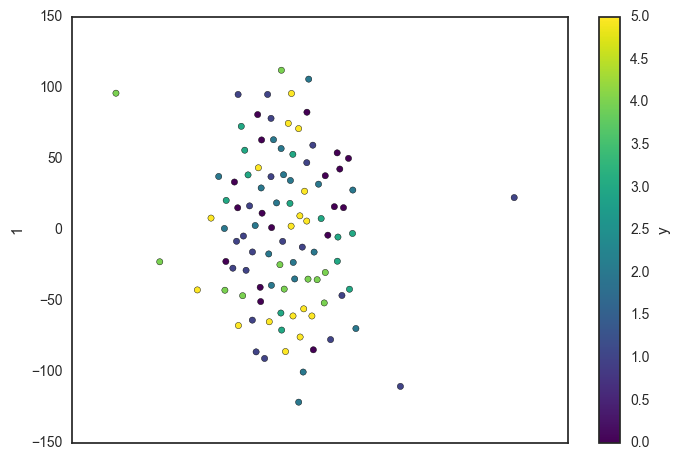

In [128]:
# take a look at the result
tsne = TSNE(perplexity=20, learning_rate=1000, metric='precomputed')
emb = pd.DataFrame(tsne.fit_transform(lcs_distances))
emb['y'] = y_pred_hac_lcs
emb['gt'] = normalised_true_labels
emb.plot(kind='scatter', x=0, y=1, c='y', cmap='viridis')

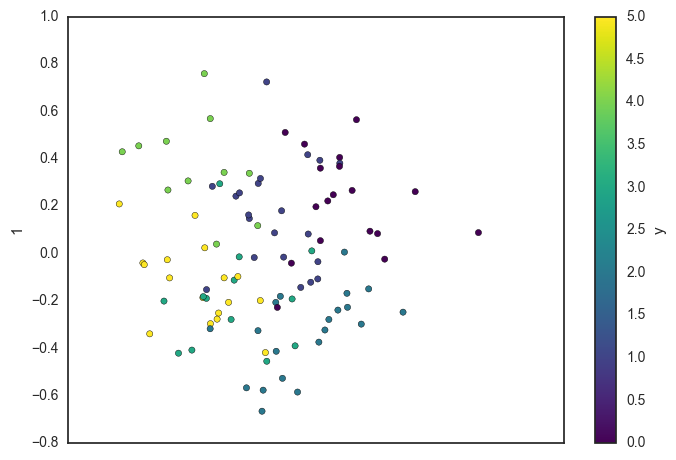

In [133]:
pca = PCA(n_components=2)
emb = pd.DataFrame(pca.fit_transform(lcs_distances))
emb['y'] = y_pred_hac_lcs
emb['gt'] = normalised_true_labels
emb.plot(kind='scatter', x=0, y=1, c='y', cmap='viridis')

In [148]:
sample[1]

s = 12

def extract_featrues(chunk):
    column = chunk[s]
    return (column.std(), column.mean())

stds = []
means = []

for chunk in sample:
    std, mean = extract_featrues(chunk)
    stds.append(std)
    means.append(mean)
    
features = pd.DataFrame({'std': stds, 'mean': means, 'true_label': normalised_true_labels, 'cluster': y_pred_hac_lcs})
features

,cluster,mean,std,true_label
0,4,-0.320097,1.338822,2
1,5,-0.412313,0.943586,3
2,1,-0.156650,1.129020,4
3,4,-0.836067,1.153810,4
4,0,0.774695,0.469983,3
5,0,-0.251256,1.369041,5
6,5,-0.022986,0.861908,2
7,3,-0.163546,0.768211,3
8,0,-0.155145,1.383622,4
9,2,0.268499,0.387616,4


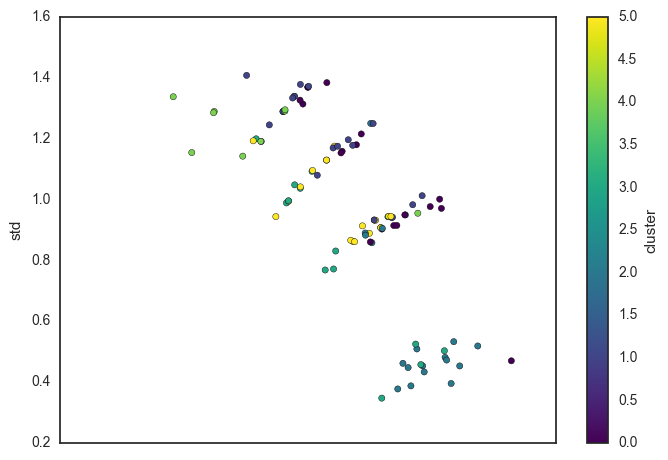

In [149]:
features.plot(kind='scatter', x='mean', y='std', c='cluster', cmap='viridis')